In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from collections import Counter
import os


In [29]:

# Verificar si el archivo existe antes de intentar leerlo
file_path = "/home/leire/Documentos/Cursos/F5/Proyectos/refuerzo/repositorio/Leire_Teleco/data/raw/dataset.csv"
if os.path.exists(file_path):
	data = pd.read_csv(file_path)
else:
	raise FileNotFoundError(f"No se encontró el archivo: {file_path}")

# Crear carpeta para guardar gráficos
output_folder = "results/visualizations"
os.makedirs(output_folder, exist_ok=True)


In [30]:
# Ajustar el estilo de las gráficas
sns.set_palette('pastel')

In [31]:
# Mapear valores categóricos para facilitar interpretación
if 'gender' in data.columns:
    data['gender_label'] = data['gender'].map({0: 'Mujer', 1: 'Hombre'})
if 'marital' in data.columns:
    data['marital_label'] = data['marital'].map({0: 'Soltero', 1: 'Casado'})
if 'retire' in data.columns:
    data['retire_label'] = data['retire'].map({0: 'No Jubilado', 1: 'Jubilado'})

In [32]:
# Inspeccionar las primeras filas
print("Primeras filas")
print("_________________")
print(data.head())

#informacion general
print("_________________")
print("Información del dataset:")
print("_________________")
print(data.info())

# Resumen estadístico
print("_________________")
print("Resumen estadístico")
print("_________________")
print(data.describe())

# Verificar valores nulos
print("_________________")
print("Valores nulos")
print("_________________")
print(data.isnull().sum())

Primeras filas
_________________
   region  tenure  age  marital  address  income  ed  employ  retire  gender  \
0       2      13   44        1        9    64.0   4       5     0.0       0   
1       3      11   33        1        7   136.0   5       5     0.0       0   
2       3      68   52        1       24   116.0   1      29     0.0       1   
3       2      33   33        0       12    33.0   2       0     0.0       1   
4       2      23   30        1        9    30.0   1       2     0.0       0   

   reside  custcat gender_label marital_label retire_label  
0       2        1        Mujer        Casado  No Jubilado  
1       6        4        Mujer        Casado  No Jubilado  
2       2        3       Hombre        Casado  No Jubilado  
3       1        1       Hombre       Soltero  No Jubilado  
4       4        3        Mujer        Casado  No Jubilado  
_________________
Información del dataset:
_________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entr

#visualizar distribuciones

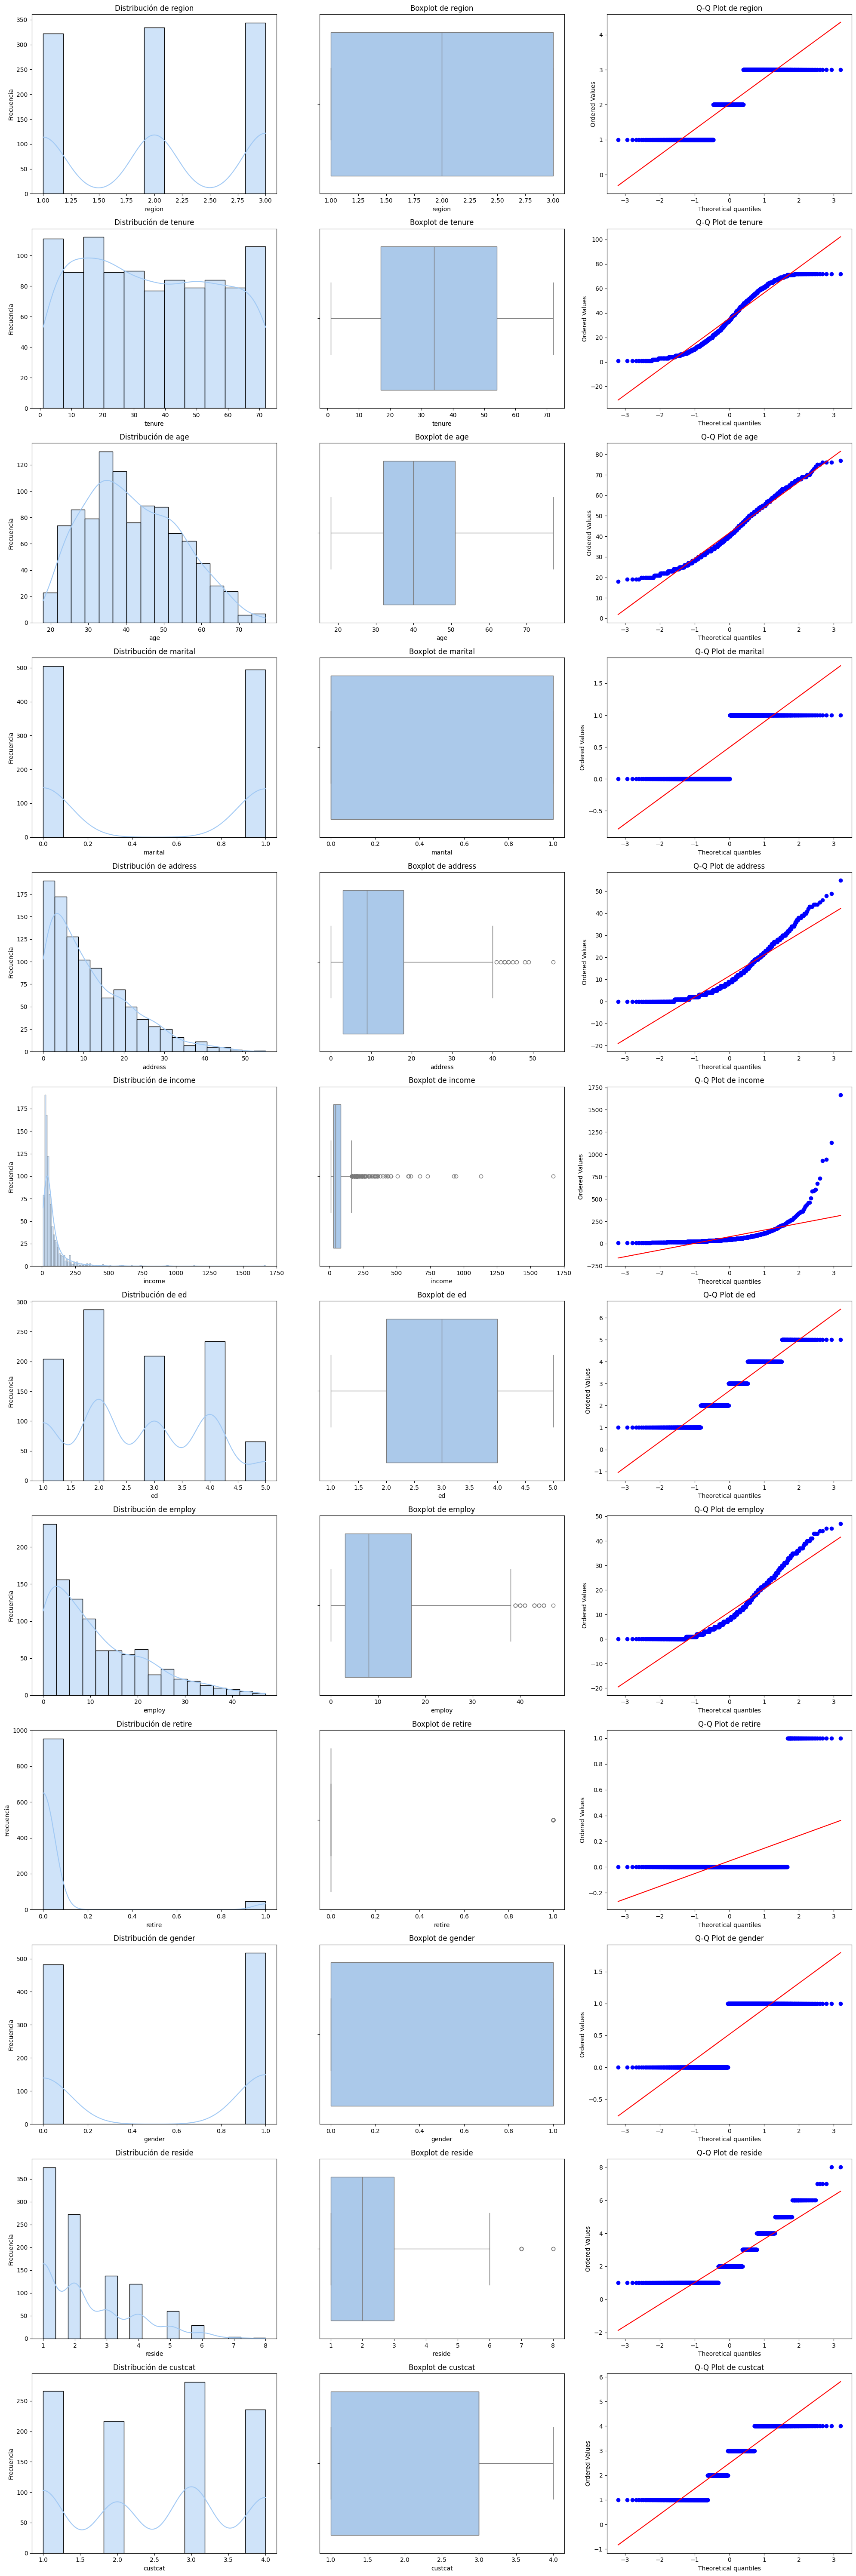

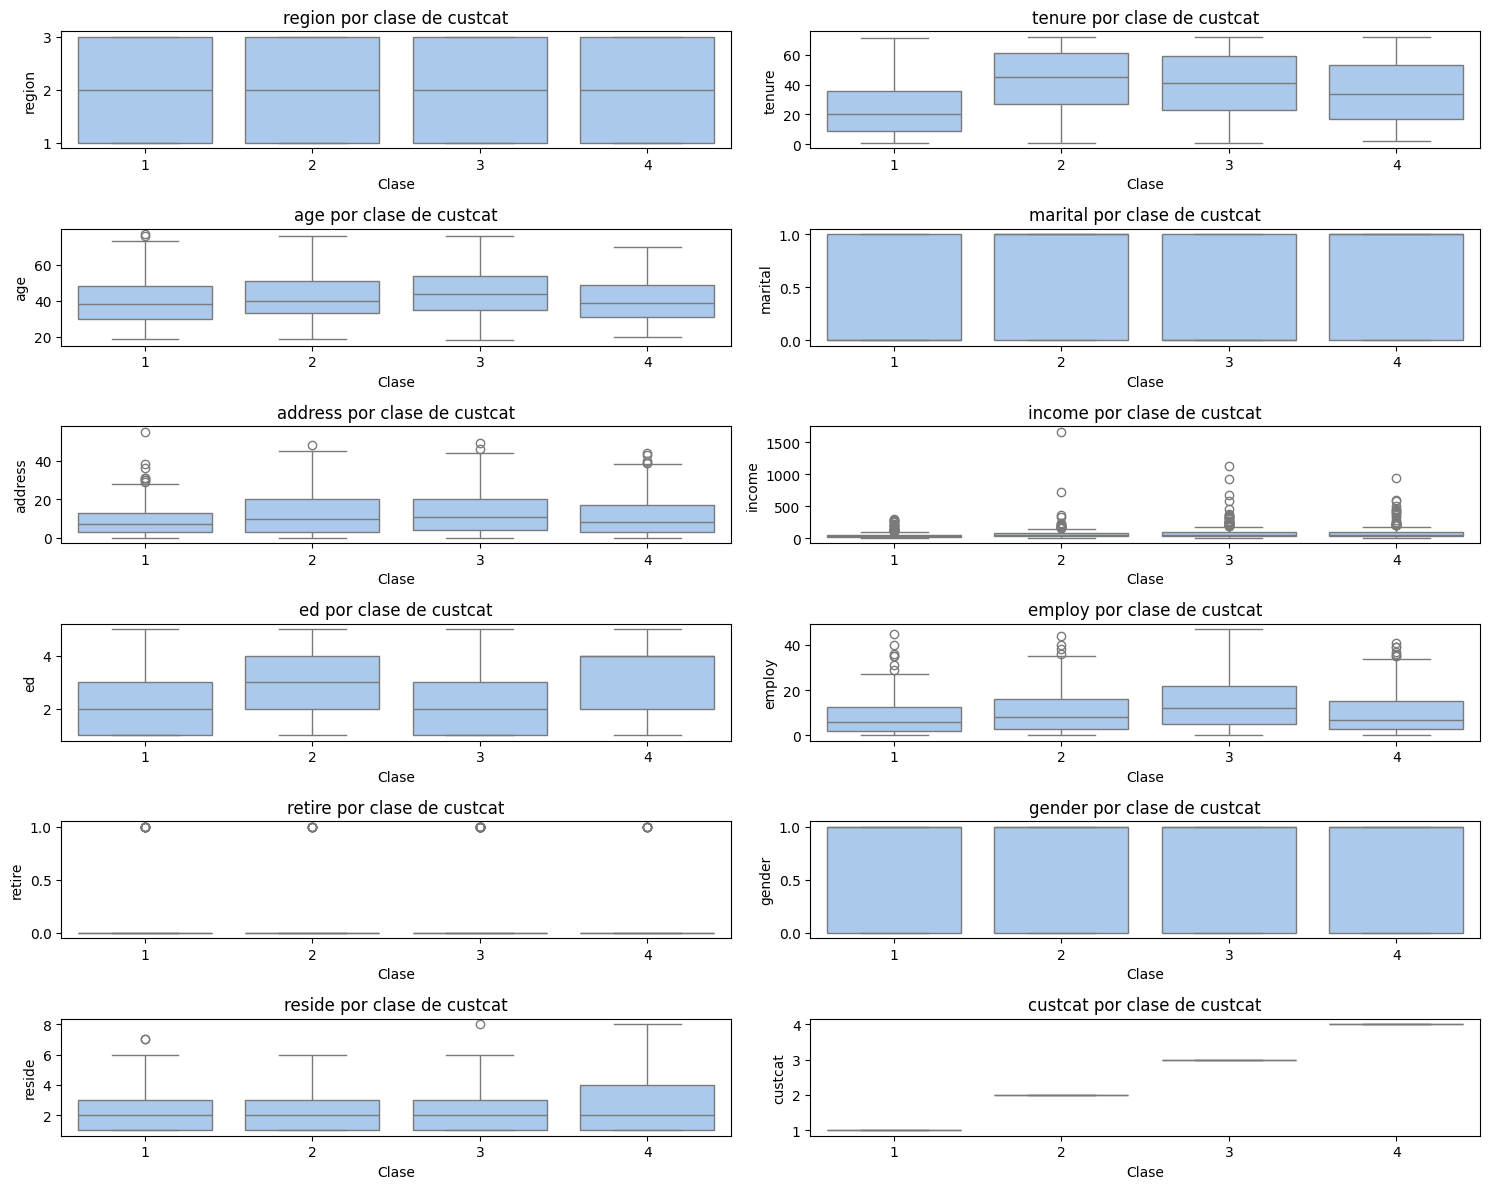

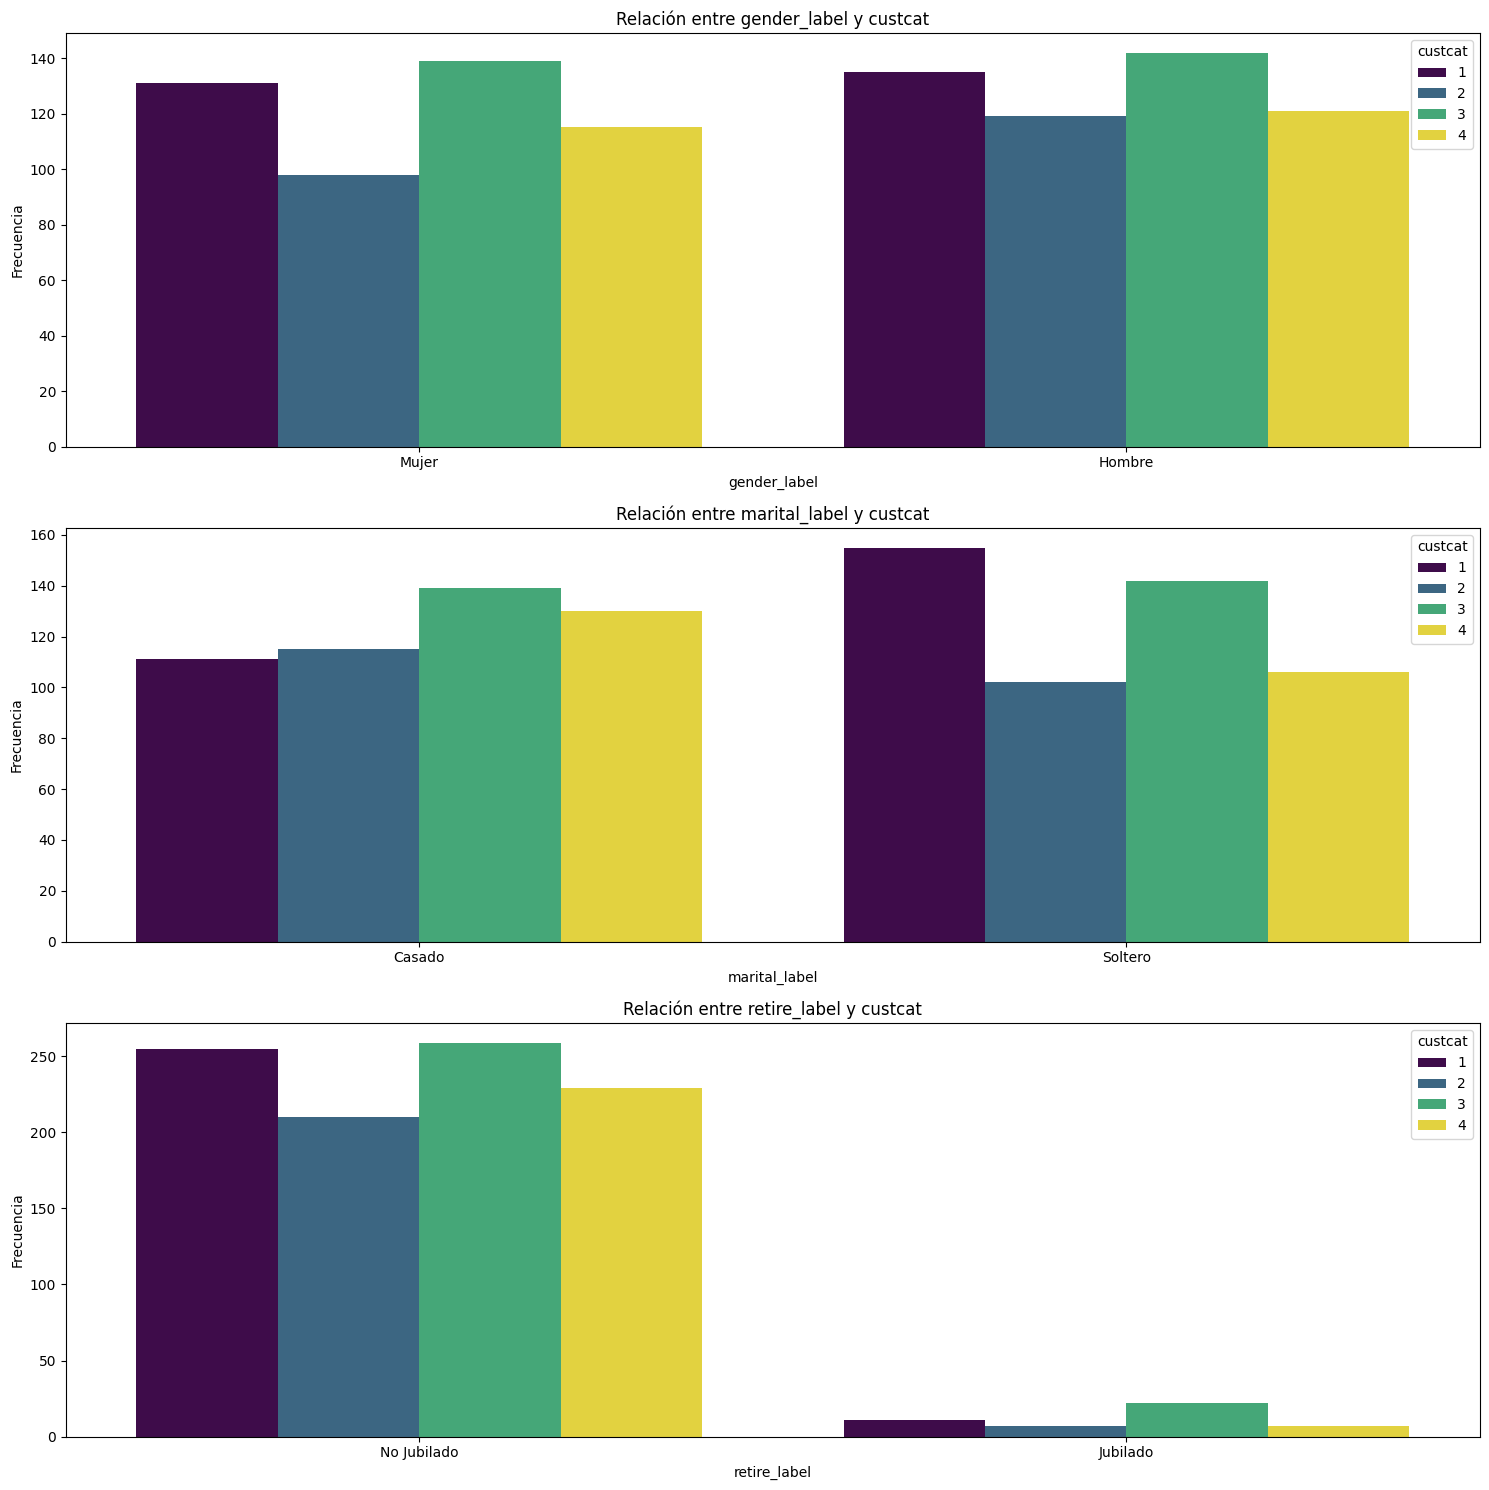

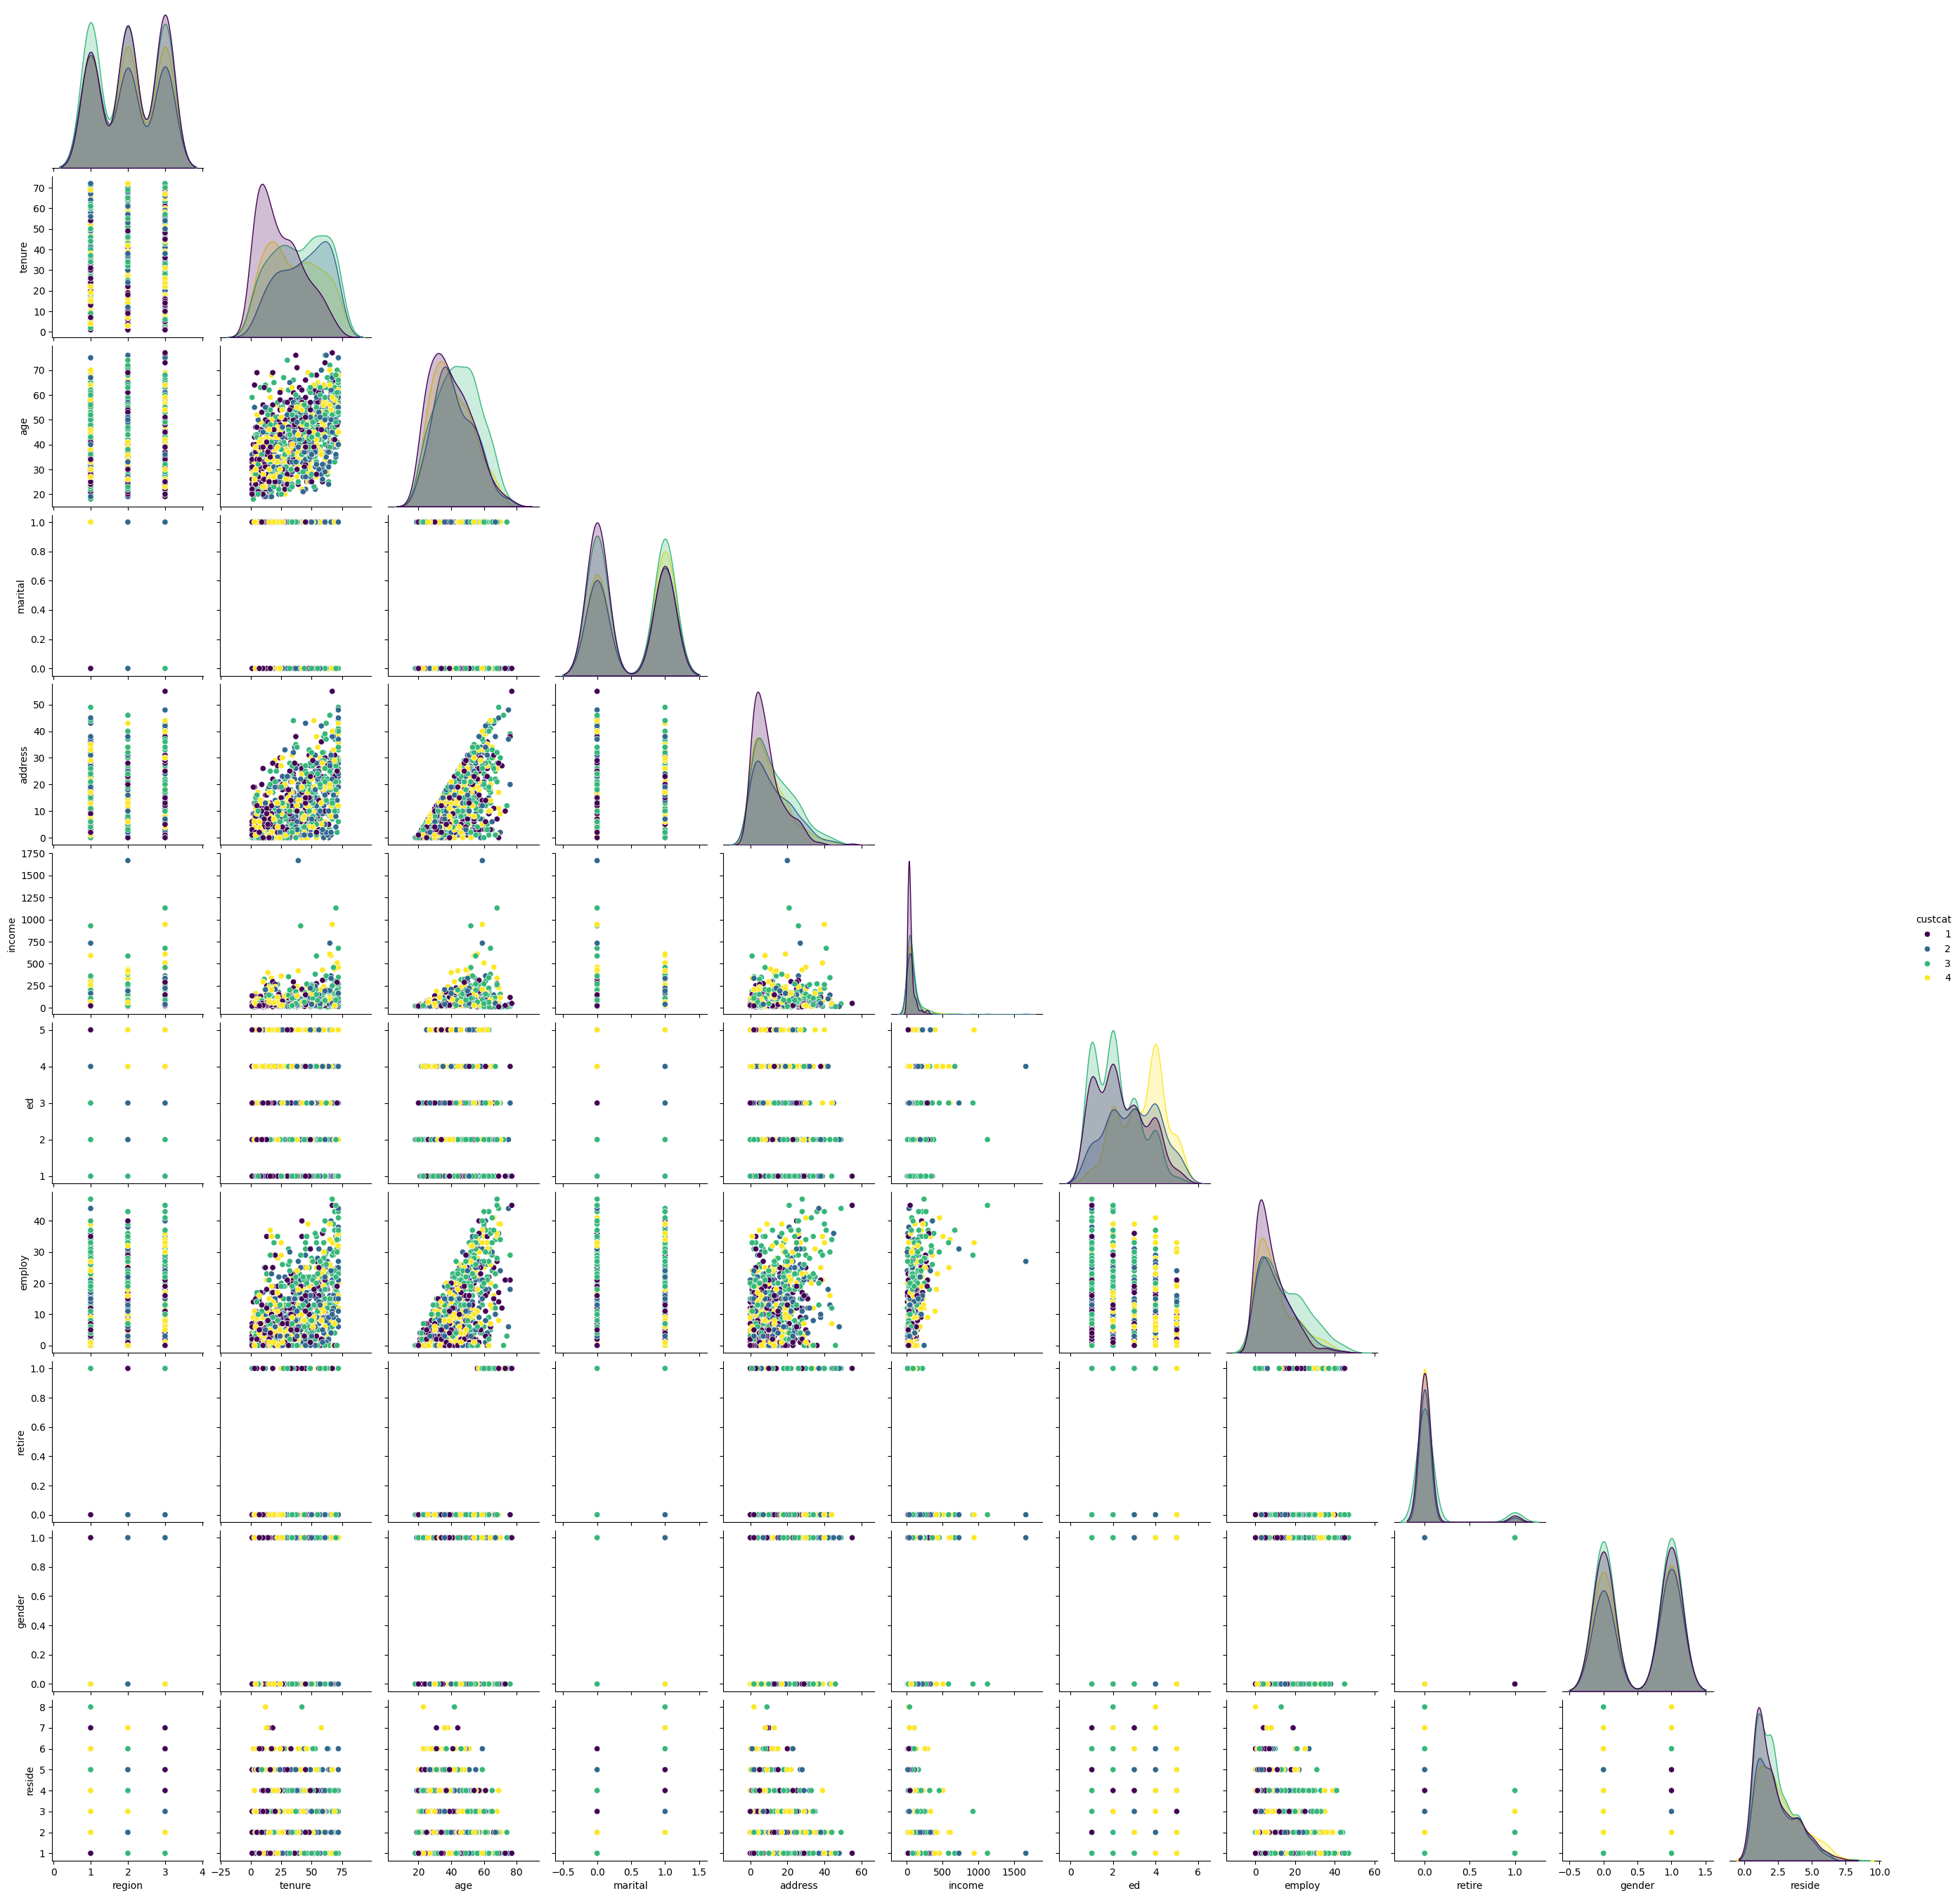

In [33]:
# Variables numéricas
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns
target_col = "custcat"

# Distribuciones de variables numéricas
fig, axes = plt.subplots(len(numeric_cols), 3, figsize=(20, 5 * len(numeric_cols)))

for i, col in enumerate(numeric_cols):
    # Histograma con KDE
    sns.histplot(data[col], kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Distribución de {col}')
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('Frecuencia')

    # Boxplot para detección de outliers
    sns.boxplot(x=data[col], ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot de {col}')
    axes[i, 1].set_xlabel(col)

    # Q-Q Plot para evaluar normalidad
    stats.probplot(data[col], dist="norm", plot=axes[i, 2])
    axes[i, 2].set_title(f'Q-Q Plot de {col}')

plt.tight_layout()
plt.savefig(os.path.join(output_folder, 'distributions_outliers_qqplots.png'))
plt.show()

# Relación entre variables numéricas y la variable objetivo
fig, axes = plt.subplots(len(numeric_cols) // 2 + len(numeric_cols) % 2, 2, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.boxplot(x=target_col, y=col, data=data, ax=axes[i])
    axes[i].set_title(f'{col} por clase de {target_col}')
    axes[i].set_xlabel('Clase')
    axes[i].set_ylabel(col)

plt.tight_layout()
plt.savefig(os.path.join(output_folder, 'numeric_vs_target.png'))
plt.show()

# Relación entre variables categóricas y la variable objetivo
categorical_cols = data.select_dtypes(include=['object', 'category']).columns

fig, axes = plt.subplots(len(categorical_cols), 1, figsize=(15, 5 * len(categorical_cols)))

for i, col in enumerate(categorical_cols):
    sns.countplot(x=col, hue=target_col, data=data, palette='viridis', ax=axes[i])
    axes[i].set_title(f'Relación entre {col} y {target_col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frecuencia')

plt.tight_layout()
plt.savefig(os.path.join(output_folder, 'categorical_vs_target.png'))
plt.show()

# 4. Relaciones entre variables numéricas (Pairplot)
sns.pairplot(data[numeric_cols], diag_kind='kde', corner=True, hue=target_col, palette='viridis')
plt.savefig(os.path.join(output_folder, 'pairplot_numeric.png'))
plt.show()


#detección outliers

In [34]:

# Lista para almacenar los índices de los outliers
outlier_indices = []

# Número de columnas en las que un índice debe ser outlier para considerarse múltiple
n = 2

# Iterar sobre las columnas numéricas
for col in numeric_cols:
    # Calcular los cuartiles y el IQR
    Q1 = np.percentile(data[col], 25)
    Q3 = np.percentile(data[col], 75)
    IQR = Q3 - Q1
    outlier_step = 1.5 * IQR

    # Identificar los índices que son outliers para la columna actual
    outlier_list_col = data[(data[col] < Q1 - outlier_step) | (data[col] > Q3 + outlier_step)].index
    outlier_indices.extend(outlier_list_col)

# Contar cuántas veces cada índice aparece como outlier
outlier_counts = Counter(outlier_indices)

# Filtrar los índices que son outliers en más de `n` columnas
multiple_outliers = [k for k, v in outlier_counts.items() if v > n]

# Imprimir el número de outliers detectados
print(f"Número de outliers detectados: {len(multiple_outliers)}")



Número de outliers detectados: 3


#Matriz correlación

Matriz de correlación guardada en results/visualizations/correlation_matrix.csv
Gráfico de matriz de correlación guardado en results/visualizations/correlation_matrix.png


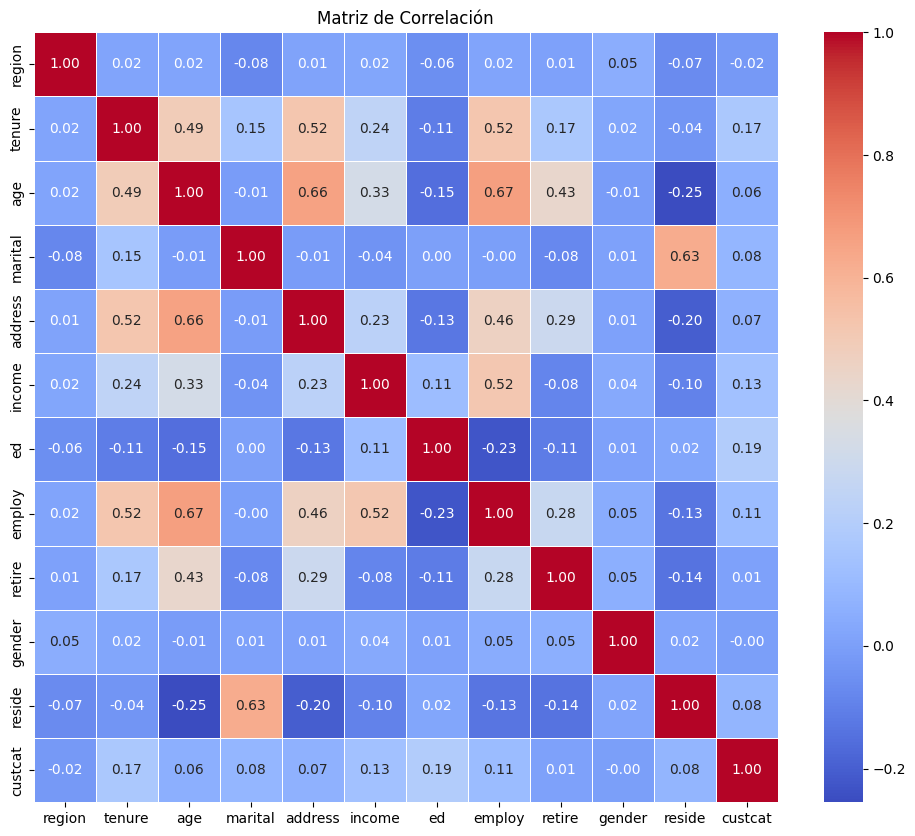

In [35]:

numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns #variables numéricas

# Calcular matriz de correlación
correlation_matrix = data[numeric_cols].corr()

# Guardar la matriz de correlación en un archivo CSV
correlation_csv_path = os.path.join(output_folder, 'correlation_matrix.csv')
correlation_matrix.to_csv(correlation_csv_path, index=True)
print(f"Matriz de correlación guardada en {correlation_csv_path}")


plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlación')


correlation_png_path = os.path.join(output_folder, 'correlation_matrix.png')
plt.savefig(correlation_png_path)
print(f"Gráfico de matriz de correlación guardado en {correlation_png_path}")
plt.show()

#VIF (factor de inflación de la varianza)

In [36]:
# Ruta del archivo de VIF generado por feature_engineering.py
vif_file = "../results/vif_analysis.csv"

# Comprobar si el archivo existe
if os.path.exists(vif_file):
    # Cargar los resultados del VIF
    vif_data = pd.read_csv(vif_file)

    # Visualización del VIF
    plt.figure(figsize=(10, 6))
    plt.barh(vif_data["feature"], vif_data["VIF"], color="skyblue")
    plt.xlabel("VIF")
    plt.ylabel("Feature")
    plt.title("Variance Inflation Factor (VIF) por Característica")
    plt.grid(axis="x", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    vif_data.to_csv(os.path.join(output_folder, 'vif_analysis.csv'), index=False)

else:
    print(f"Archivo {vif_file} no encontrado. Ejecuta feature_engineering.py para generarlo.")

# Guardar los resultados en un archivo CSV para referencia



Archivo ../results/vif_analysis.csv no encontrado. Ejecuta feature_engineering.py para generarlo.


In [37]:
# Ruta para guardar los datos limpios
cleaned_data_path = "../data/processed/data_cleaned.csv"
processed_dir = os.path.dirname(cleaned_data_path)

# Crear la carpeta si no existe
if not os.path.exists(processed_dir):
    os.makedirs(processed_dir)
    print(f"Carpeta creada: {processed_dir}")

# Guardar el archivo
data.to_csv(cleaned_data_path, index=False)
print(f"Archivo limpio guardado en: {cleaned_data_path}")
print("EDA completado. Las visualizaciones se han guardado en la carpeta 'eda_visualizations'.")

Archivo limpio guardado en: ../data/processed/data_cleaned.csv
EDA completado. Las visualizaciones se han guardado en la carpeta 'eda_visualizations'.
